# Master Experiment Notebook

This notebook contains the basic structure of a test. We set up some data from our datasets, implement a simple ngmix measurement from that, and compare to  autodiff and finitediff from autometacal.

Data can have:

- some coherent shear applied to all galaxies
- some level of noise applied to them

The goal is to get the following experiments running:

1. How the performance compares? If we do 100 blocks of 1000 galaxies, how long does it take for autometacal, vs ngmix?
2. Can AutoMetaCal perform better than ngmix by using smaller PSFs?
3. How does Autodiff vs Finitediff vs ngmix compare with realistic galaxies?
4. How does Autodiff vs ngmix go with model fitting?

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tqdm

import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf
import galflow as gf
import ngmix

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
batch_size=1000
data= tfds.load('GalGen/small_stamp_1k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

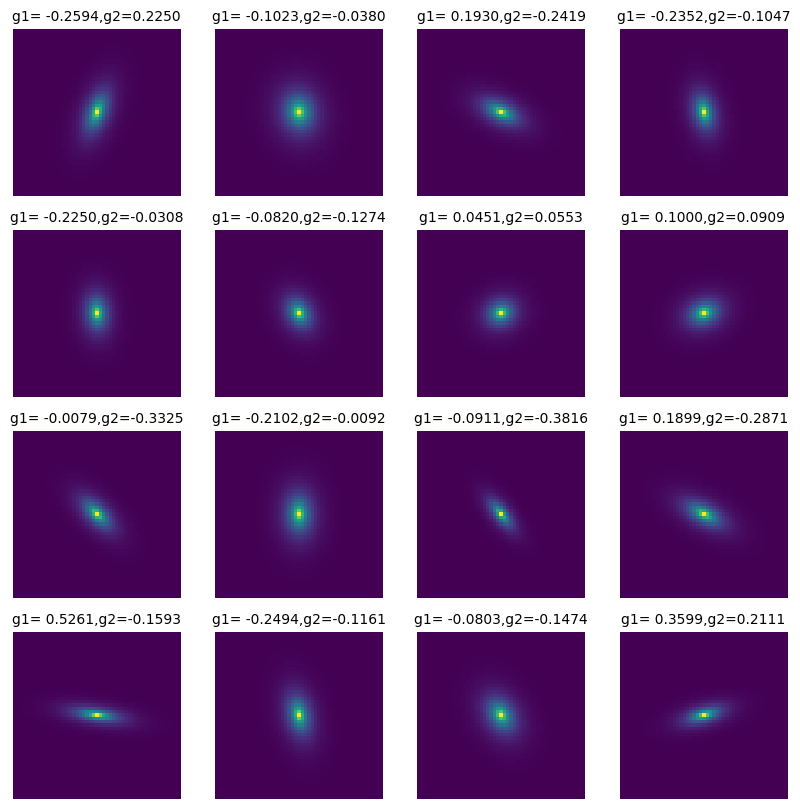

In [4]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
gal_images = onebatch['gal_model'] 
labels = onebatch['label'] 
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i],origin='lower')
  title(f"g1= {labels[i][0]:.4f},g2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

In [5]:
sheared=amc.noiseless_real_mcal_image(onebatch['gal_model'],onebatch['psf_image'],
                          tf.repeat([[0.,0.01]],len(onebatch['gal_model']),axis=0))

noise_level = 1e-3
noise = np.random.normal(scale=noise_level,size=[1000,51,51])
sheared += noise

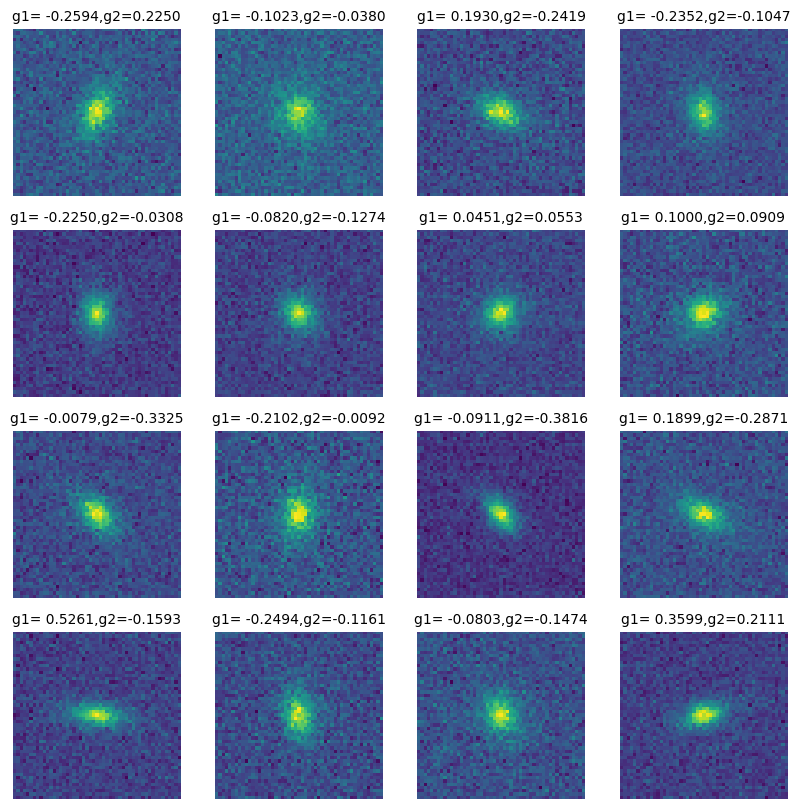

In [6]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(sheared[i],origin= 'lower')
  #imshow(gal_images[i],origin='lower')
  title(f"g1= {labels[i][0]:.4f},g2={labels[i][1]:.4f}",fontsize=10)
  axis('off')

In [7]:
im = sheared[0]
psf_im = onebatch['psf_image'][0] 

In [8]:
scale= .2
stamp_size = 51

jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)
psf_jacobian = ngmix.DiagonalJacobian(
  row=stamp_size//2, 
  col=stamp_size//2,
  scale=scale,
)

In [9]:
wt = tf.reduce_mean(1.0/(noise)**2,axis=0)
psf_wt = tf.reduce_mean(1.0/(noise/100)**2,axis=0)

psf_obs = ngmix.Observation(
  psf_im,
  weight=psf_wt,
  jacobian=psf_jacobian,
)
obs = ngmix.Observation(
  im,
  jacobian=jacobian,
  weight=wt,
  psf=psf_obs,
)

In [10]:
rng = np.random.RandomState(31415)

# We will measure moments with a fixed gaussian weight function
weight_fwhm = 1.2
fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both 
# psf and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent

types = ['noshear', '1p', '1m','2p','2m']
boot = ngmix.metacal.MetacalBootstrapper(
  runner=runner, psf_runner=psf_runner,
  rng=rng,
  psf='gauss',
  types=types,
  fixnoise=True,
)

In [11]:
resdict, obsdict = boot.go(obs)

In [12]:
def get_metacal_response_ngmix(resdict):
  step=0.01
  types = ['noshear', '1p', '1m','2p','2m']
  e1, e2 = resdict['noshear']['e1'], resdict['noshear']['e2']
 
  g0s = np.array([resdict['noshear']['e1'], resdict['noshear']['e2']])
  g1p = np.array([resdict['1p']['e1'], resdict['1p']['e2']])
  g1m = np.array([resdict['1m']['e1'], resdict['1m']['e2']])
  g2p = np.array([resdict['2p']['e1'], resdict['2p']['e2']])
  g2m = np.array([resdict['2m']['e1'], resdict['2m']['e2']])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)  
   
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])
    
  return ellip_dict, R


  

## Shakedown Test!

In [13]:
true = labels[0]
#ngmix calibration
ellips, R_ngmix = get_metacal_response_ngmix(resdict)
calibrated_ngmix = linalg.inv(R_ngmix) @ ellips['noshear']
#AutoMetaCal run
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)
R_auto = amc.get_metacal_response(im[tf.newaxis], psf_im[tf.newaxis],psf_im[tf.newaxis],method)
e_amc=method(im[tf.newaxis])
calibrated_amc = linalg.inv(R_auto[1][0].numpy()) @ e_amc[0].numpy()

In [14]:
print("True:")
print(f"e1={true[0]:.6f}, e2={true[1]:.6f}.")

print("\nngmix:")
print(f"e1={calibrated_ngmix[0]:.6f}, e2={calibrated_ngmix[1]:.6f}.")

print("\nAutoMetaCal")
print(f"e1={calibrated_amc[0]:.6f}, e2={calibrated_amc[1]:.6f}.")

True:
e1=-0.259441, e2=0.224996.

ngmix:
e1=-0.241803, e2=0.284177.

AutoMetaCal
e1=-0.239201, e2=0.281108.


# One Batch Test